## Hybrid Deep Learning Model for HyperspectralvImage Super-resolution with Gradient-Aware Loss Optimization

In [1]:
import numpy as np
import tensorflow as tf
import random
import os
from spectral import open_image
from scipy.io import loadmat 
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Activation, Add, Concatenate, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, UpSampling2D, Concatenate, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import structural_similarity as ssim

2025-02-18 14:06:10.247000: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-18 14:06:10.262613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739880370.278634 1066063 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739880370.283600 1066063 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 14:06:10.300496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Set all seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Ensure TensorFlow uses deterministic operations
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load the Pavia dataset
try:
    data = loadmat("PaviaU.mat")  # Ensure that the file path is correct
except Exception as e:
    raise ValueError(f"Error loading .mat file: {e}")

# Access the hyperspectral image using the correct key 'paviaU'
print("Keys in loaded .mat file:", data.keys())
if 'paviaU' in data:
    hyperspectral_image = data['paviaU']
else:
    raise KeyError("'paviaU' not found in the .mat file.")

# Check the shape of the hyperspectral image
print("Hyperspectral image shape:", hyperspectral_image.shape)

# Convert to float32 for TensorFlow operations
hyperspectral_image = hyperspectral_image.astype(np.float32)

# Parameters
patch_size = (144, 144)  # Size of patches to extract
test_size = 0.2  # Proportion of data for testing
validation_size = 0.1  # Proportion of data for validation
downscale_factor = 2  # Factor to downscale patches
nodata_value = -1  # Value that indicates "no data"
group_size = 6  # Group size for spectral bands
overlap_size = 2  # Overlap size for grouped bands

# Function to group bands into overlapping subgroups
def group_bands_with_overlap(data, group_size=6, overlap_size=2):
    height, width, bands = data.shape
    step_size = group_size - overlap_size  # Calculate step size based on overlap
    grouped_data = []

    # Create overlapping groups of bands
    for g in range(0, bands - group_size + 1, step_size):
        group = data[:, :, g:g + group_size]
        grouped_data.append(group)
    
    return np.array(grouped_data)

# Extract and downscale patches from hyperspectral data
def extract_and_downscale_patches(data, patch_size, downscale_factor, nodata_value=0):
    patches_hr = []
    patches_lr = []
    height, width, bands = data.shape

    for i in range(0, height - patch_size[0] + 1, patch_size[0]):
        for j in range(0, width - patch_size[1] + 1, patch_size[1]):
            patch_hr = data[i:i + patch_size[0], j:j + patch_size[1], :]

            # Check for nodata_value and skip patch extraction if present
            if np.any(patch_hr == nodata_value):
                continue
            
            patch_lr = tf.image.resize(patch_hr, 
                                       [patch_size[0] // downscale_factor, patch_size[1] // downscale_factor], 
                                       method='bilinear')
            patches_hr.append(patch_hr)
            patches_lr.append(patch_lr.numpy())  # Convert tensor to numpy

    return np.array(patches_hr), np.array(patches_lr)

# Group bands into overlapping subgroups
grouped_data = group_bands_with_overlap(hyperspectral_image, group_size=group_size, overlap_size=overlap_size)

# Extract and downscale patches for all groups
all_patches_hr = []
all_patches_lr = []

for group in grouped_data:
    patches_hr, patches_lr = extract_and_downscale_patches(group, patch_size, downscale_factor, nodata_value=nodata_value)
    all_patches_hr.append(patches_hr)
    all_patches_lr.append(patches_lr)

# Convert lists to numpy arrays before shuffling
all_patches_hr = np.array(all_patches_hr)
all_patches_lr = np.array(all_patches_lr)

# Concatenate patches from all groups
all_patches_hr = np.concatenate(all_patches_hr, axis=0)
all_patches_lr = np.concatenate(all_patches_lr, axis=0)

# Calculate the number of patches
num_patches = len(all_patches_hr)

# Calculate sizes for training, validation, and testing sets
train_size = int((1 - test_size - validation_size) * num_patches)
validation_size = int(validation_size * num_patches)
test_size = num_patches - (train_size + validation_size)  # Explicit calculation of test size

# Shuffle indices for splitting the data
indices = np.arange(num_patches)
np.random.shuffle(indices)
all_patches_hr = all_patches_hr[indices]
all_patches_lr = all_patches_lr[indices]

# Split into training, validation, and testing sets
X_train_hr, X_validation_hr, X_test_hr = np.split(all_patches_hr, [train_size, train_size + validation_size])
X_train_lr, X_validation_lr, X_test_lr = np.split(all_patches_lr, [train_size, train_size + validation_size])

# Print shapes to verify
print("X_train_hr shape:", X_train_hr.shape)
print("X_validation_hr shape:", X_validation_hr.shape)
print("X_test_hr shape:", X_test_hr.shape)

print("X_train_lr shape:", X_train_lr.shape)
print("X_validation_lr shape:", X_validation_lr.shape)
print("X_test_lr shape:", X_test_lr.shape)


Keys in loaded .mat file: dict_keys(['__header__', '__version__', '__globals__', 'paviaU'])
Hyperspectral image shape: (610, 340, 103)


I0000 00:00:1739880374.994782 1066063 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


X_train_hr shape: (140, 144, 144, 6)
X_validation_hr shape: (20, 144, 144, 6)
X_test_hr shape: (40, 144, 144, 6)
X_train_lr shape: (140, 72, 72, 6)
X_validation_lr shape: (20, 72, 72, 6)
X_test_lr shape: (40, 72, 72, 6)


In [3]:

# Spatial–Spectral Gradient Loss Function
def spatial_spectral_gradient_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_true - y_pred))
    
    def spatial_gradient_loss(y_true, y_pred):
        grad_y_true_x = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
        grad_y_pred_x = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]
        grad_y_true_y = y_true[:, 1:, :, :] - y_true[:, :-1, :, :]
        grad_y_pred_y = y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :]
        
        loss_x = K.mean(K.square(grad_y_true_x - grad_y_pred_x))
        loss_y = K.mean(K.square(grad_y_true_y - grad_y_pred_y))
        
        return loss_x + loss_y

    def spectral_gradient_loss(y_true, y_pred):
        grad_y_true_spectral = y_true[:, :, :, 1:] - y_true[:, :, :, :-1]
        grad_y_pred_spectral = y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1]
        return K.mean(K.square(grad_y_true_spectral - grad_y_pred_spectral))

    spatial_loss = spatial_gradient_loss(y_true, y_pred)
    spectral_loss = spectral_gradient_loss(y_true, y_pred)
    
    total_loss = mse_loss + 0.1 * spatial_loss + 0.1 * spectral_loss
    return total_loss

# Residual Block
def residual_block(x, filters=32):
    res = Conv2D(filters, (3, 3), padding='same')(x)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)
    res = Conv2D(filters, (3, 3), padding='same')(res)
    res = BatchNormalization()(res)
    return Add()([x, res])

# Spectral–Spatial Block
def spectral_spatial_block(x, filters=32):
    spatial = Conv2D(filters, (3, 3), padding='same')(x)
    spatial = BatchNormalization()(spatial)
    spatial = Activation('relu')(spatial)
    
    spectral = Conv2D(filters, (1, 1), padding='same')(x)
    spectral = BatchNormalization()(spectral)
    spectral = Activation('relu')(spectral)
    
    spatial = Conv2D(filters, (1, 1), padding='same')(spatial)
    
    combined = Concatenate(axis=-1)([spatial, spectral])
    return combined

# Spectral Unmixing Block
def spectral_unmixing_block(x, num_endmembers=10):
    x = Conv2D(num_endmembers, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)
    return x

# General Upsampling Block (Supports Transpose and Standard Upsampling)
def upsample_block(x, filters, scale=2, use_transpose=True):
    if use_transpose:
        x = Conv2DTranspose(filters, (3, 3), strides=(scale, scale), padding='same')(x)
    else:
        x = UpSampling2D(size=(scale, scale))(x)
        x = Conv2D(filters, (3, 3), padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Build Model with Configurable Upsampling
def build_hybrid_sr_model(input_shape, num_endmembers=40, use_transpose=True):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (9, 9), padding='same')(inputs)
    x = Activation('relu')(x)
    
    for _ in range(50):
        x = residual_block(x)
    
    x = spectral_spatial_block(x)
    
    x_unmixed = spectral_unmixing_block(x, num_endmembers)
    
    x_concat = Concatenate(axis=-1)([x, x_unmixed])
    
    x_up = upsample_block(x_concat, filters=64, scale=2, use_transpose=use_transpose)  # 2x upscaling
 #   x_up = upsample_block(x_up, filters=32, scale=2, use_transpose=use_transpose)  # 4x upscaling
    
    x_out = Conv2D(input_shape[-1], (3, 3), padding='same')(x_up)
    x_out = Activation('linear')(x_out)
    
    model = Model(inputs=inputs, outputs=x_out)
    return model

# Define input shape and build model
input_shape = (72, 72, 6)
num_endmembers = 40
use_transpose = True  # Set to False if you want to use UpSampling2D instead

hybrid_sr_model = build_hybrid_sr_model(input_shape, num_endmembers=num_endmembers, use_transpose=use_transpose)

# Compile the model with the custom loss function
hybrid_sr_model.compile(optimizer='adam', loss=spatial_spectral_gradient_loss)

Epoch 1/1000


I0000 00:00:1739880395.841891 1066155 service.cc:148] XLA service 0x7fba40015da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739880395.841916 1066155 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-02-18 14:06:36.271175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739880397.946972 1066155 cuda_dnn.cc:529] Loaded cuDNN version 90501


 8/35 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3110499.2500

I0000 00:00:1739880403.180911 1066155 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - loss: 2680415.7500 - val_loss: 2616904.7500
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2637507.2500 - val_loss: 2677935.5000
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2576587.7500 - val_loss: 2538986.2500
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2509119.5000 - val_loss: 2445487.7500
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2434546.5000 - val_loss: 2338448.7500
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2352515.2500 - val_loss: 2227730.5000
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2262496.5000 - val_loss: 2198097.2500
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2166038.2500 - val_loss: 2104262.5000
Epoch 9/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2063201.6250 - val_loss: 2041722.3750
Epoch 10/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1955502.0000 - val_loss: 1878926.7500
Epoch 11/1000
35/35 ━

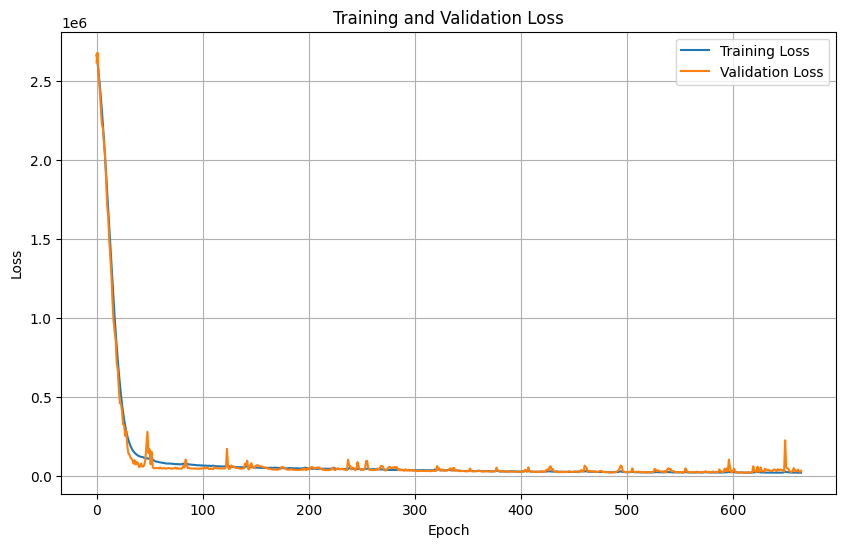

In [4]:
### # Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model and get the training history with early stopping
history = hybrid_sr_model.fit(
    X_train_lr, 
    X_train_hr, 
    epochs=1000, 
    batch_size=4, 
    validation_data=(X_validation_lr, X_validation_hr),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

# Visualize training and validation loss over epochs
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

In [5]:

def psnr(y_true, y_pred, max_pixel=None):
    """
    Compute PSNR for each spectral band separately and return the average.
    
    Args:
        y_true: Ground truth image, shape (H, W, B)
        y_pred: Super-resolved image, shape (H, W, B)
        max_pixel: Maximum pixel value (None = use actual max from y_true)
    
    Returns:
        Average PSNR across all bands
    """
    if max_pixel is None:
        max_pixel = np.max(y_true)  # Auto-detect max value if not provided

    B = y_true.shape[-1]  # Number of spectral bands
    psnr_values = []
    
    for i in range(B):  # Loop over bands
        mse = np.mean((y_true[..., i] - y_pred[..., i]) ** 2)
        if mse == 0:
            psnr_values.append(float('inf'))  # Perfect reconstruction
        else:
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    
    return np.mean(psnr_values)  # Average across bands

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")
    
    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])
    
    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))
    
    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0
    
    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")
    
    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        
        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0
    
    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)
        
        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band
        
        ergas_value += (rmse_band / mean_band_true) ** 2
    
    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images = hybrid_sr_model.predict(X_test_lr, batch_size=4)

downscale_factor = 2 # ERGAS downscale factor

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    ergas_values.append(ergas(X_test_hr[i], predicted_hr_images[i], downscale_factor))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average ERGAS on the test set:", average_ergas)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Average PSNR on the test set: 36.56230972210566
Average SSIM on the test set: 0.9620744
Average SAM on the test set (in degrees): 2.307285634247239
Average Correlation Coefficient on the test set: 0.9848624424136148
Average ERGAS on the test set: 4.330103749248037
Average RMSE: 0.015558141
